# Librairies

In [1]:
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pylab as plt

# Load data

In [2]:
gdf = gpd.read_file('raw/SHP_OTC_COMPTAGE_TRAFIC/OTC_COMPTAGE_TRAFIC.shp')

In [3]:
gdf.dtypes

OBJECTID         int64
NO_SIREDO      float64
NO_PT_MES       object
CODE_VOIE       object
NOM_VOIE        object
DIRECTION       object
TJOM             int64
TJOM_ANNEE      object
TJM            float64
TJM_ANNEE       object
DISPONIBLE      object
ANGLE          float64
PRESELECT       object
ID_GM_TRON     float64
CAPTEUR         object
DATEDT          object
NOM_POINT_      object
HPM            float64
HPS            float64
geometry      geometry
dtype: object

In [14]:
gdf.DIRECTION.value_counts()

DIRECTION
Entrée ville                    60
Sortie ville                    57
Genève                          44
France                          39
Lausanne                        12
                                ..
Rte Grand-Lancy                  1
Entrée ville surface             1
de Ge-Châtelaine vers France     1
Place Albert-Thomas              1
de Lausanne vers Meyrin          1
Name: count, Length: 157, dtype: int64

In [15]:
gdf[gdf.TJOM==4538]

,OBJECTID,NO_SIREDO,NO_PT_MES,CODE_VOIE,NOM_VOIE,DIRECTION,TJOM,TJOM_ANNEE,TJM,TJM_ANNEE,DISPONIBLE,ANGLE,PRESELECT,ID_GM_TRON,CAPTEUR,DATEDT,NOM_POINT_,HPM,HPS,geometry
28,127,3186.2,3187,90824,Vessy,Carouge,4538,2017,3796.0,2017,3 semaines/an,290.0,Toutes_DIrections,111578.0,PERIOD,20210514161056,Vessy (Pont),471.0,223.0,POINT (2501284.28 1115204.7)


(2473204.417220493, 2514604.6734708287, 1103065.402451095, 1144148.8200056376)

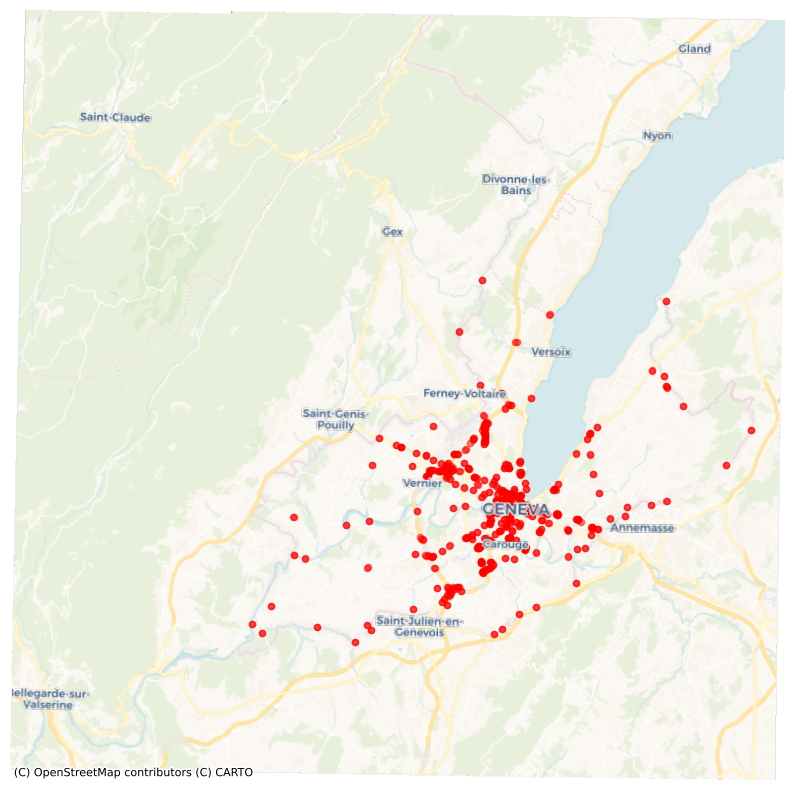

In [9]:
import contextily as cx

# Plot sensors
ax = gdf.plot(color = 'r', markersize = 20, alpha = .5, figsize = (10,10))
# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [10]:
gdf.columns

Index(['OBJECTID', 'NO_SIREDO', 'NO_PT_MES', 'CODE_VOIE', 'NOM_VOIE',
       'DIRECTION', 'TJOM', 'TJOM_ANNEE', 'TJM', 'TJM_ANNEE', 'DISPONIBLE',
       'ANGLE', 'PRESELECT', 'ID_GM_TRON', 'CAPTEUR', 'DATEDT', 'NOM_POINT_',
       'HPM', 'HPS', 'geometry'],
      dtype='object')

In [16]:
gdf.TJM_ANNEE.unique()

array(['2019', '2015', '2017', '2012', '2021', '0', '2022'], dtype=object)

In [17]:
# Remove year '0'
gdf = gdf[gdf.TJM_ANNEE != '0']

In [18]:
(gdf.TJM_ANNEE == gdf.TJOM_ANNEE).sum() == gdf.shape[0]

True

In [20]:
gdf.rename(
    columns = {
        'TJOM' : 'AAWT', 
        'TJM' : 'AADT', 
        'TJM_ANNEE' : 'year', 
        'NOM_VOIE':'raw_name',
        'DIRECTION':'raw_direction'
    }, 
    inplace = True
)

C:\Users\xbonnema\AppData\Local\Temp\ipykernel_35508\3890162819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.rename(


In [21]:
gdf.year.value_counts().sort_index()

year
2012      8
2015     55
2017    112
2019    321
2021      2
2022      2
Name: count, dtype: int64

In [22]:
# We keep only 2019 and 2017

gdf = gdf[gdf.year.isin(['2017', '2019'])]

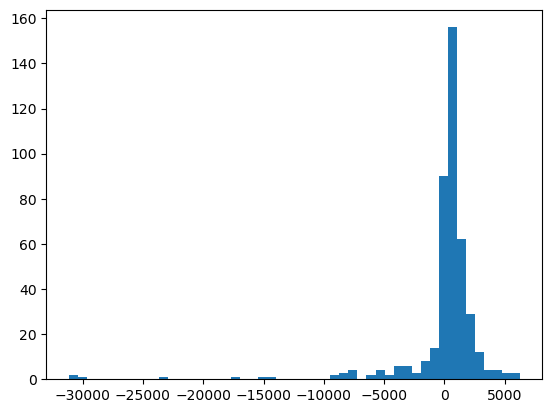

In [23]:
plt.hist(gdf.AAWT - gdf.AADT, bins = 50)
plt.show()
# SOme AAWT values seem pretty low compared to AADT ones

In [24]:
gdf.columns

Index(['OBJECTID', 'NO_SIREDO', 'NO_PT_MES', 'CODE_VOIE', 'raw_name',
       'raw_direction', 'AAWT', 'TJOM_ANNEE', 'AADT', 'year', 'DISPONIBLE',
       'ANGLE', 'PRESELECT', 'ID_GM_TRON', 'CAPTEUR', 'DATEDT', 'NOM_POINT_',
       'HPM', 'HPS', 'geometry'],
      dtype='object')

In [25]:
gdf['raw_oneway'] = True

In [26]:
gdf = gdf[[
    'AAWT',  'AADT',  'raw_name', 'raw_oneway', 'raw_direction', 'geometry', 'year'
]].to_crs('epsg:4326')

# Map matching with OSM

In [27]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import points_matching

In [28]:
gdf = points_matching(gdf)

City downloaded


100%|██████████| 433/433 [00:03<00:00, 120.68it/s]

We failed to match 0 sensors
...on a total of 433 sensors


In [29]:
gdf[['raw_name', 'osm_name']].drop_duplicates().dropna()[:20]

,raw_name,osm_name
0,ADOR,Quai Gustave-Ador
2,Mandement,Route du Mandement
5,Voie-Centrale,Voie Centrale
6,Ferney,Route de Ferney
7,Ecole-de-Médecine,Rue de l'Ecole-de-Médecine
8,Lausanne,Rue de Lausanne
9,Croisette,Chemin de la Croisette
10,Saint-Jean,Rue de Saint-Jean
11,Veyrier,Route de Veyrier
12,Ecu,Viaduc de l'Écu


# Final saving

In [33]:
for year in ['2017', '2019'] :

    gdf[gdf.year == year].drop('year', axis = 1).to_file(
        f'treated/Geneva_AADT_AAWT_{year}.geojson', index = False
    )